In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

drqn_csv = pd.read_csv("drqn_test_log.csv")
dqn_csv = pd.read_csv("dqn_test_log.csv")
offload_csv = pd.read_csv("offload_only_test_log.csv")
local_csv = pd.read_csv("local_only_test_log.csv")

drqn = drqn_csv[drqn_csv["epoch"]==19]["reward"]
dqn = dqn_csv[dqn_csv["epoch"]==19]["reward"]
offload = offload_csv[offload_csv["epoch"]==19]["reward"]
local = local_csv[local_csv["epoch"]==19]["reward"]

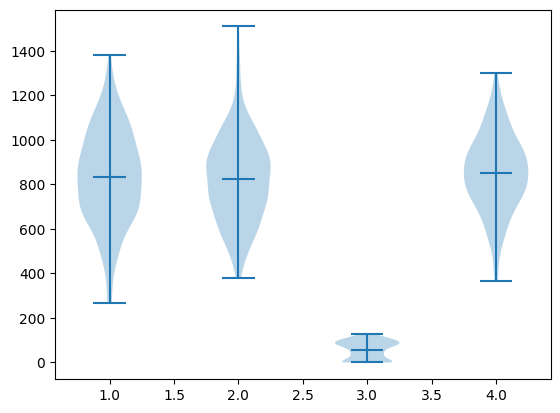

In [10]:
fig, ax = plt.subplots()
violin = ax.violinplot([drqn, dqn, offload, local], showmeans=True)